In [6]:
import json 
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(1)
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Masa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
with open("data/filtered/abusive_hateful_spam_normal.json") as f:
    data = json.load(f)

data_tag = 'ahs'  # can also be 'ahs' for the other dataset
print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [86]:
if data_tag == 'srb':
    racism = []
    benevolent = []
    sexism = []
    for id, tweet in data.items():
        text = tweet["text"]
        if(len(text) == 0):
            continue
        if tweet["label"] == "sexism":
            sexism.append(text)
        if tweet["label"] == "benevolent":
            benevolent.append(text)
        if tweet["label"] == "racism":
            racism.append(text)
        if tweet["label"] == "both":
            sexism.append(text)
            racism.append(text)
    print(len(racism))
    print(len(sexism))
    print(len(benevolent))

    labels = []
    labels.extend(["R"] * len(racism))
    labels.extend(["S"] * len(sexism))
    labels.extend(["B"] * len(benevolent))
    print(len(labels))

    texts = []
    texts.extend(racism)
    texts.extend(benevolent)
    texts.extend(sexism)
    print(len(texts))
    
if data_tag == 'ahs':
    abusive = []
    hateful = []
    spam = []
    for id, tweet in data.items():
        text = tweet["text"]
        if(len(text) == 0):
            continue
        if tweet["label"] == "abusive":
            abusive.append(text)
        if tweet["label"] == "hateful":
            hateful.append(text)
        if tweet["label"] == "spam":
            spam.append(text)
    
    print(len(abusive))
    print(len(hateful))
    print(len(spam))

    labels = []
    #labels.extend(["A"] * len(abusive))
    labels.extend(["H"] * len(hateful))
    #labels.extend(["S"] * len(spam))
    print(len(labels))

    texts = []
    #texts.extend(abusive)
    texts.extend(hateful)
    #texts.extend(spam)
    print(len(texts))

4227
1752
7782
1752
1752


In [87]:
def preprocess(A):
    B = []
  
    for i in range(len(A)):

        text = A[i]
        # remove old style retweet text "RT"
        text = re.sub(r'^RT[\s]+', '', text)

        # remove hyperlinks
        text= re.sub(r'https?:\/\/.*[\r\n]*', '', text)

        # remove hashtags
        # only removing the hash # sign from the word
        text = re.sub(r'#', '', text)

        # remove tagging @
        text = re.sub(r"(?:\@|https?\://)\S+", "", text)

        # remove new line \n
        text = re.sub("\n", "", text)

        # remove zero length tweets
        if(len(text) == 0 ):
            continue

        B.append(text)
        
    return B

In [88]:
texts = preprocess(texts)

In [90]:
stopwords = list(gensim.parsing.preprocessing.STOPWORDS)
print(len(stopwords))
stopwords.extend(["like", "damn"])
print(len(stopwords))
stemmer = SnowballStemmer("english")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    
    for token in gensim.utils.simple_preprocess(text):
        if token not in stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result


337
339


In [91]:
res = []
for text in texts:
    res.append(preprocess(text))


In [92]:
dictionary = gensim.corpora.Dictionary(res)
print(dictionary)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

Dictionary(4099 unique tokens: ['bruh', 'fuck', 'hate', 'peopl', 'bronco']...)
0 bruh
1 fuck
2 hate
3 peopl
4 bronco
5 dawg
6 dumbass
7 fanbas
8 swear
9 bitch
10 chase


In [93]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [94]:
bow_corpus = [dictionary.doc2bow(doc) for doc in res]


In [95]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.6465738233197383), (1, 0.46775878648002933), (2, 0.6026143117022912)]


In [96]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=2, id2word=dictionary, passes=2, workers=2)

In [97]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.061*"hate" + 0.057*"peopl" + 0.039*"trump" + 0.034*"idiot" + 0.029*"know" + 0.027*"need" + 0.024*"hell" + 0.023*"syria" + 0.022*"bitch" + 0.022*"say"


Topic: 1 
Words: 0.097*"nigga" + 0.057*"hate" + 0.054*"idiot" + 0.043*"fuck" + 0.023*"trump" + 0.021*"look" + 0.020*"bitch" + 0.020*"stupid" + 0.018*"kill" + 0.018*"think"




In [98]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=2, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))
    print("\n")

Topic: 0 Word: 0.036*"nigga" + 0.030*"bitch" + 0.026*"look" + 0.023*"hell" + 0.023*"want" + 0.021*"peopl" + 0.021*"trump" + 0.020*"hate" + 0.019*"kill" + 0.016*"stupid"


Topic: 1 Word: 0.069*"hate" + 0.063*"idiot" + 0.048*"nigga" + 0.037*"fuck" + 0.031*"peopl" + 0.026*"know" + 0.026*"trump" + 0.023*"think" + 0.022*"need" + 0.020*"say"




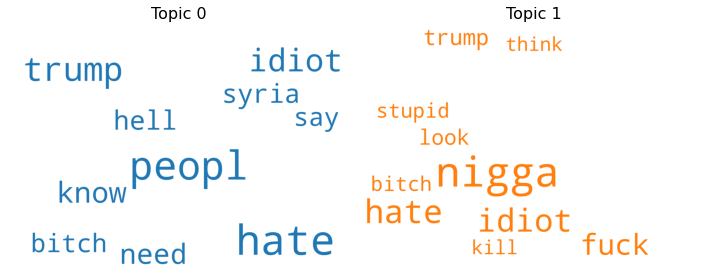

In [99]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()